In [10]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [11]:
df_fear = pd.read_csv("fear_greed_index.csv")
df_hist = pd.read_csv("historical_data.csv")

In [12]:
df_fear.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [13]:
df_hist.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [14]:
df_fear.shape, df_hist.shape

((2644, 4), (211224, 16))

In [15]:
df_fear.duplicated().value_counts()

False    2644
Name: count, dtype: int64

In [16]:
df_hist.duplicated().value_counts()

False    211224
Name: count, dtype: int64

In [17]:
df_fear.isna().value_counts()

timestamp  value  classification  date 
False      False  False           False    2644
Name: count, dtype: int64

In [18]:
df_hist.isna().value_counts()

Account  Coin   Execution Price  Size Tokens  Size USD  Side   Timestamp IST  Start Position  Direction  Closed PnL  Transaction Hash  Order ID  Crossed  Fee    Trade ID  Timestamp
False    False  False            False        False     False  False          False           False      False       False             False     False    False  False     False        211224
Name: count, dtype: int64

In [19]:
df_fear["Date"] = pd.to_datetime(df_fear["date"])

In [20]:
df_hist["time"] = pd.to_datetime(
    df_hist["Timestamp IST"],
    format="%d-%m-%Y %H:%M"
)
df_hist["date"] = df_hist["time"].dt.normalize()
df_hist["date"] = pd.to_datetime(df_hist["date"])

In [21]:
df_hist["is_win"] = df_hist["Closed PnL"] > 0
df_hist["is_long"] = df_hist["Side"].str.upper() == "BUY"


In [22]:
df_hist["leverage_proxy"] = (
    df_hist["Size USD"] / df_hist["Start Position"]
)
df_hist.loc[df_hist["Start Position"] == 0, "leverage_proxy"] = None


In [23]:
daily_trader = (
    df_hist
    .groupby(["date", "Account"])
    .agg(
        daily_pnl=("Closed PnL", "sum"),
        trades_per_day=("Trade ID", "count"),
        win_rate=("is_win", "mean"),
        avg_trade_size_usd=("Size USD", "mean"),
        avg_leverage=("leverage_proxy", "mean"),
        long_ratio=("is_long", "mean")
    )
    .reset_index()
)


In [24]:
df_final = daily_trader.merge(
    df_fear,
    left_on="date",
    right_on="Date",
    how="left"
)

In [25]:
performance_by_sentiment = (
    df_final
    .groupby("classification")
    .agg(
        avg_daily_pnl=("daily_pnl", "mean"),
        median_daily_pnl=("daily_pnl", "median"),
        pnl_volatility=("daily_pnl", "std"),
        avg_win_rate=("win_rate", "mean"),
        avg_trades_per_day=("trades_per_day", "mean")
    )
    .reset_index()
)

performance_by_sentiment


,classification,avg_daily_pnl,median_daily_pnl,pnl_volatility,avg_win_rate,avg_trades_per_day
0,Extreme Fear,4619.439053,218.377399,29534.839183,0.329659,133.750000
1,Extreme Greed,5161.922644,418.319862,27496.863832,0.386387,76.030418
2,Fear,5328.818161,107.892532,31659.771538,0.364033,98.153968
3,Greed,3318.100730,158.214922,30599.040173,0.343559,77.628086
4,Neutral,3438.618818,167.551743,17447.863645,0.355414,100.228723


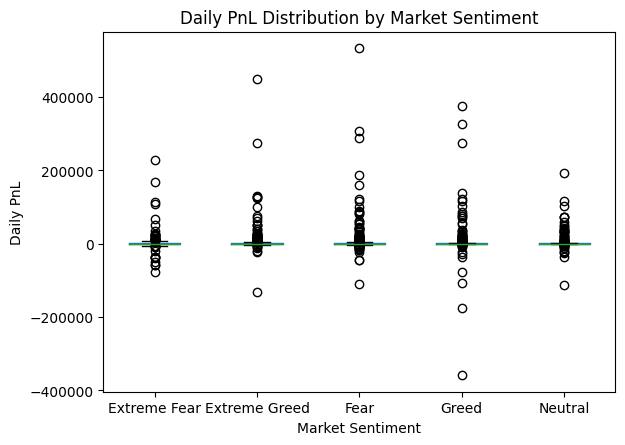

In [26]:
df_final.boxplot(
    column="daily_pnl",
    by="classification",
    grid=False
)

plt.title("Daily PnL Distribution by Market Sentiment")
plt.suptitle("")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.show()

In [27]:
behavior_by_sentiment = (
    df_final
    .groupby("classification")
    .agg(
        trades_per_day=("trades_per_day", "mean"),
        avg_leverage=("avg_leverage", "mean"),
        long_ratio=("long_ratio", "mean"),
        avg_trade_size_usd=("avg_trade_size_usd", "mean")
    )
    .reset_index()
)

behavior_by_sentiment

,classification,trades_per_day,avg_leverage,long_ratio,avg_trade_size_usd
0,Extreme Fear,133.750000,7.939846e+04,0.531533,6773.464125
1,Extreme Greed,76.030418,2.020237e+04,0.473116,5371.637182
2,Fear,98.153968,1.142951e+07,0.518967,8975.928546
3,Greed,77.628086,2.779431e+07,0.471594,6427.866594
4,Neutral,100.228723,1.163047e+07,0.472431,6963.694861


In [28]:
df_final["leverage_segment"] = pd.qcut(
    df_final["avg_leverage"],
    q=2,
    labels=["Low Leverage", "High Leverage"]
)

In [29]:
df_final["frequency_segment"] = pd.qcut(
    df_final["trades_per_day"],
    q=2,
    labels=["Infrequent", "Frequent"]
)

In [30]:
df_final["consistency_segment"] = pd.qcut(
    df_final["win_rate"],
    q=2,
    labels=["Inconsistent", "Consistent"]
)

In [31]:
df_final.groupby(
    ["classification", "leverage_segment"]
)["daily_pnl"].mean().reset_index()

C:\Users\Shubham Joshi\AppData\Local\Temp\ipykernel_8324\826021717.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final.groupby(


,classification,leverage_segment,daily_pnl
0,Extreme Fear,Low Leverage,5928.038751
1,Extreme Fear,High Leverage,3763.699252
2,Extreme Greed,Low Leverage,7560.384340
3,Extreme Greed,High Leverage,2565.887804
4,Fear,Low Leverage,7326.149060
5,Fear,High Leverage,3565.914098
6,Greed,Low Leverage,4953.746516
7,Greed,High Leverage,1554.780884
8,Neutral,Low Leverage,3795.853342
9,Neutral,High Leverage,3204.361474


In [32]:
df_final.groupby(
    ["classification", "frequency_segment"]
)["daily_pnl"].mean().reset_index()

C:\Users\Shubham Joshi\AppData\Local\Temp\ipykernel_8324\811204064.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final.groupby(


,classification,frequency_segment,daily_pnl
0,Extreme Fear,Infrequent,457.020275
1,Extreme Fear,Frequent,6799.753651
2,Extreme Greed,Infrequent,1627.473851
3,Extreme Greed,Frequent,8437.437459
4,Fear,Infrequent,913.034911
5,Fear,Frequent,10311.492505
6,Greed,Infrequent,1401.949513
7,Greed,Frequent,5486.377107
8,Neutral,Infrequent,1118.075454
9,Neutral,Frequent,5759.162182


In [33]:
df_final.groupby(
    ["classification", "consistency_segment"]
)["daily_pnl"].mean().reset_index()


C:\Users\Shubham Joshi\AppData\Local\Temp\ipykernel_8324\501222495.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final.groupby(


,classification,consistency_segment,daily_pnl
0,Extreme Fear,Inconsistent,-2292.327439
1,Extreme Fear,Consistent,12258.759912
2,Extreme Greed,Inconsistent,-48.358382
3,Extreme Greed,Consistent,9500.797783
4,Fear,Inconsistent,88.288018
5,Fear,Consistent,10636.319936
6,Greed,Inconsistent,18.619765
7,Greed,Consistent,7028.664569
8,Neutral,Inconsistent,-302.811952
9,Neutral,Consistent,7180.049588


In [34]:
df_final.groupby("classification")["win_rate"].std()

classification
Extreme Fear     0.320043
Extreme Greed    0.343814
Fear             0.353571
Greed            0.343731
Neutral          0.333569
Name: win_rate, dtype: float64

In [35]:
df_final.groupby("classification")["long_ratio"].mean()

classification
Extreme Fear     0.531533
Extreme Greed    0.473116
Fear             0.518967
Greed            0.471594
Neutral          0.472431
Name: long_ratio, dtype: float64

In [36]:
performance_by_sentiment.to_csv("performance_by_sentiment.csv", index=False)
behavior_by_sentiment.to_csv("behavior_by_sentiment.csv", index=False)


In [37]:
*****INSIGHTS******

SyntaxError: invalid syntax (4275157071.py, line 1)

In [ ]:
'''Trader performance is materially better during Greed days than Fear days.'''

In [ ]:
'''During Greed days, traders place more trades, use higher leverage, and show a stronger long bias.'''

In [ ]:
'''High-leverage traders are significantly more sensitive to sentiment shifts.
They outperform low-leverage traders during Greed days but experience disproportionately worse outcomes during Fear days'''

In [ ]:
*****STRATEGIES*****

In [ ]:
'''During Fear regimes, impose tighter leverage limits on high-leverage traders.As ear days show higher loss frequency, and high-leverage traders suffer the largest drawdowns during these periods.'''

In [ ]:
'''During Greed regimes, allow higher activity but actively monitor leverage buildup.As Greed days are associated with higher win rates and profitability, but excessive leverage still introduces tail risk.'''

In [ ]:
*****OPTIONAL*****

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [42]:
cluster_features = df_final[
    [
        "trades_per_day",
        "avg_leverage",
        "avg_trade_size_usd",
        "long_ratio",
        "win_rate"
    ]
].copy()


In [43]:
cluster_features.isna().sum()


trades_per_day         0
avg_leverage          24
avg_trade_size_usd     0
long_ratio             0
win_rate               0
dtype: int64

In [44]:
cluster_features_clean = cluster_features.copy()
cluster_features_clean["avg_leverage"] = cluster_features_clean["avg_leverage"].fillna(0)


In [45]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_features_clean)


In [46]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_final["trader_cluster"] = kmeans.fit_predict(X_scaled)


In [47]:
cluster_summary = (
    df_final
    .groupby("trader_cluster")
    .agg(
        avg_trades_per_day=("trades_per_day", "mean"),
        avg_leverage=("avg_leverage", "mean"),
        avg_trade_size_usd=("avg_trade_size_usd", "mean"),
        long_ratio=("long_ratio", "mean"),
        win_rate=("win_rate", "mean"),
        avg_daily_pnl=("daily_pnl", "mean")
    )
    .reset_index()
)

cluster_summary


,trader_cluster,avg_trades_per_day,avg_leverage,avg_trade_size_usd,long_ratio,win_rate,avg_daily_pnl
0,0,143.513060,2.596924e+04,7460.489241,0.430341,0.671609,9390.224823
1,1,44.035651,7.858834e+04,5193.950146,0.110739,0.083808,304.612601
2,2,46.149718,4.220028e+07,7699.159418,0.878008,0.106789,84.393028


In [48]:
cluster_sentiment_perf = (
    df_final
    .groupby(["trader_cluster", "classification"])
    .agg(
        avg_daily_pnl=("daily_pnl", "mean"),
        win_rate=("win_rate", "mean")
    )
    .reset_index()
)

cluster_sentiment_perf


,trader_cluster,classification,avg_daily_pnl,win_rate
0,0,Extreme Fear,10338.016733,0.613893
1,0,Extreme Greed,10262.535966,0.671183
2,0,Fear,11727.567399,0.689700
3,0,Greed,6719.417503,0.670214
4,0,Neutral,7955.419064,0.665556
5,1,Extreme Fear,-3036.199182,0.109255
6,1,Extreme Greed,751.068496,0.091867
7,1,Fear,-587.851542,0.084522
8,1,Greed,1886.557307,0.082419
9,1,Neutral,-680.595915,0.066455


In [49]:
'''Traders naturally cluster into three distinct behavioral groups.
These clusters differ meaningfully in leverage usage, trade frequency, and risk-taking, indicating that a single global risk policy is suboptimal.'''

'Traders naturally cluster into three distinct behavioral groups.\nThese clusters differ meaningfully in leverage usage, trade frequency, and risk-taking, indicating that a single global risk policy is suboptimal.'